In [1]:
!pip install -q transformers
!pip install torch
!pip install pandas
!pip install numpy

import torch
import pandas as pd
import numpy as np
from transformers import pipeline

sentiment_pipeline = pipeline("sentiment-analysis")
data = ["I love you", "I hate you"]
sentiment_pipeline(data)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 113.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.9998656511306763},
 {'label': 'NEGATIVE', 'score': 0.9991129040718079}]

In [2]:
torch.cuda.is_available()

True

In [3]:
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


In [4]:
from datasets import load_dataset
imdb = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])


In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [7]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)
 
tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [8]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [10]:
import numpy as np
from datasets import load_metric
 
def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")
  
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [13]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [14]:
from transformers import TrainingArguments, Trainer
 
repo_name = "finetuning-sentiment-model-3000-samples"
 
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Cloning https://huggingface.co/Stankface/finetuning-sentiment-model-3000-samples into local empty directory.


In [15]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 3000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 376
  Number of trainable parameters = 66955010
The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster th

Step,Training Loss


Saving model checkpoint to finetuning-sentiment-model-3000-samples/checkpoint-188
Configuration saved in finetuning-sentiment-model-3000-samples/checkpoint-188/config.json
Model weights saved in finetuning-sentiment-model-3000-samples/checkpoint-188/pytorch_model.bin
tokenizer config file saved in finetuning-sentiment-model-3000-samples/checkpoint-188/tokenizer_config.json
Special tokens file saved in finetuning-sentiment-model-3000-samples/checkpoint-188/special_tokens_map.json
tokenizer config file saved in finetuning-sentiment-model-3000-samples/tokenizer_config.json
Special tokens file saved in finetuning-sentiment-model-3000-samples/special_tokens_map.json
Saving model checkpoint to finetuning-sentiment-model-3000-samples/checkpoint-376
Configuration saved in finetuning-sentiment-model-3000-samples/checkpoint-376/config.json
Model weights saved in finetuning-sentiment-model-3000-samples/checkpoint-376/pytorch_model.bin
tokenizer config file saved in finetuning-sentiment-model-3000

TrainOutput(global_step=376, training_loss=0.28649035920488075, metrics={'train_runtime': 317.276, 'train_samples_per_second': 18.911, 'train_steps_per_second': 1.185, 'total_flos': 783875831546880.0, 'train_loss': 0.28649035920488075, 'epoch': 2.0})

In [16]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 300
  Batch size = 16
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.


<ipython-input-10-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


{'eval_loss': 0.3116750419139862,
 'eval_accuracy': 0.8733333333333333,
 'eval_f1': 0.8733333333333333,
 'eval_runtime': 7.0731,
 'eval_samples_per_second': 42.414,
 'eval_steps_per_second': 2.686,
 'epoch': 2.0}

In [ ]:
trainer.push_to_hub()

In [18]:
from transformers import pipeline
 
sentiment_model = pipeline(model="federicopascual/finetuning-sentiment-model-3000-samples")
sentiment_model(["I love this move", "This movie sucks!"])

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/config.json
Model config DistilBertConfig {
  "_name_or_path": "federicopascual/finetuning-sentiment-model-3000-samples",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finet

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.

All the weights of DistilBertForSequenceClassification were initialized from the model checkpoint at federicopascual/finetuning-sentiment-model-3000-samples.
If your task is similar to the task the model of the checkpoint was trained on, you can already use DistilBertForSequenceClassification for predictions without further training.


loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--federicopascual--finetuning-sentiment-model-3000-samples/snapshots/11f7d327123ebcddd97304c57084c6365628dda5/tokenizer_config.json


[{'label': 'LABEL_1', 'score': 0.9558863043785095},
 {'label': 'LABEL_0', 'score': 0.9413502216339111}]

In [82]:
csvdir = '/content/MetaComment.csv'
df = pd.read_csv('/content/MetaComment.csv')
temp = sentiment_model([a for a in df['comments']])

In [85]:
df['BERT_label'] = [a['label'] for a in temp]

df['BERT_score'] = [a['score'] for a in temp]

In [65]:
type(temp)

transformers.pipelines.pt_utils.PipelineIterator

In [79]:
# df['BERT_score'] = pd.Series([a['score'] for a in temp])
# for obj in temp:
#   df['BERT_score'] = obj.score



# dict = {}

# for obj in temp:
#   dict.update(obj)

# for x in range(len(dict)):
#   df['BERT_score'] = dict['score']

ValueError: ignored

In [47]:
# for a in temp:
#   df['BERT_score'] = [b['score'] for b in a]

In [92]:
df.drop(columns=['Unnamed: 0'])
df['BERT_label'] = df['BERT_label'].replace({'LABEL_0':'negative', 'LABEL_1':'positive'})
df[50:60]

,Unnamed: 0,comments,TextBlob_polarity,TextBlob_subjectivity,BERT_label,BERT_score
50,50,the metaverse seems scary especially with all ...,-0.166667,0.766667,negative,0.909216
51,51,if you watch social network you definitely rea...,0.284722,0.448611,positive,0.983556
52,52,look im just going to come out and say it goo...,-0.038889,0.602485,negative,0.883454
53,53,any time zuck has to speak in public its solid...,0.000000,0.083333,negative,0.823082
54,54,the most disgusting thing is that they always ...,-0.275000,0.675000,negative,0.971911
55,55,every time theres a break in major technologic...,0.148864,0.290152,positive,0.756039
56,56,i never really got into facebook its weird at ...,-0.183333,0.545833,negative,0.962440
57,57,even with personal data these companies have a...,0.171845,0.420490,negative,0.941537
58,58,i suspect meta would be having an easier go at...,0.087500,0.515625,positive,0.553028
59,59,and isnt it great to know that no matter how m...,0.171429,0.688095,positive,0.852849


save csv file

In [93]:
df.to_csv(r'/content/FINISHED.csv')

data visualization

In [94]:
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [104]:
!pip install pyplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement pyplot (from versions: none)
ERROR: No matching distribution found for pyplot


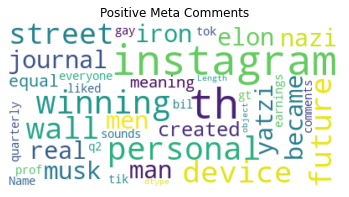

In [116]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib as plt
 
# Wordcloud with positive tweets
positive_tweets = df['comments'][df["BERT_label"] == 'positive']
stop_words = ["https", "co", "RT","meta","metaverse","mark","zuckerberg","mark zuckerberg","facebook"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_tweets))
plt.pyplot.figure()
plt.pyplot.title("Positive Meta Comments")
plt.pyplot.imshow(positive_wordcloud, interpolation="bilinear")
plt.pyplot.axis("off")
plt.pyplot.show()
 


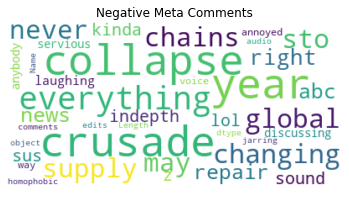

In [118]:
# Wordcloud with negative tweets
negative_tweets = df['comments'][df["BERT_label"] == 'negative']
stop_words = ["https", "co", "RT","meta","metaverse","mark","zuckerberg","mark zuckerberg","facebook","facebooks"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_tweets))
plt.pyplot.figure()
plt.pyplot.title("Negative Meta Comments")
plt.pyplot.imshow(negative_wordcloud, interpolation="bilinear")
plt.pyplot.axis("off")
plt.pyplot.show()

BERT_label
negative    1244
neutral      553
positive     377
dtype: int64


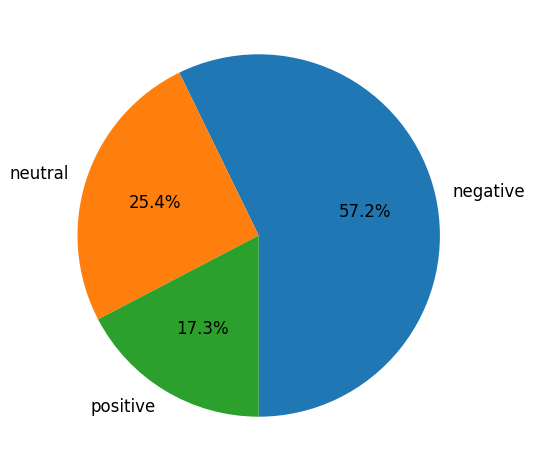

In [121]:
df = pd.read_csv('/content/NEG NEU POS.csv')

sentiment_counts = df.groupby(['BERT_label']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.pyplot.figure(figsize=(6,6), dpi=100)
ax = plt.pyplot.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

TextBlob_label
negative     529
neutral     1098
positive     547
dtype: int64


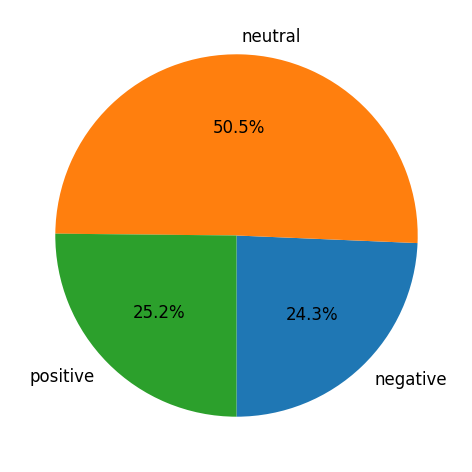

In [4]:
import matplotlib as plt
import pandas as pd


df = pd.read_csv('/content/TextBlobLabel.csv')
sentiment_counts = df.groupby(['TextBlob_label']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.pyplot.figure(figsize=(6,6), dpi=100)
ax = plt.pyplot.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")